## Some State Space Model Tricks 

In this notebook, I plan to explore a few tricks that can be easily implemented for Bayesian estimation of state space models when using the joint likelihood approach described in ["Differentiable State-Space Models
and Hamiltonian Monte Carlo Estimation"](https://donskerclass.github.io/files/pdf/hmc_dssm.pdf) and implemented in the accompanying library [DifferentiableStateSpaceModels.jl](https://github.com/HighDimensionalEconLab/DifferentiableStateSpaceModels.jl). For an introduction to use of that library to fit linear and nonlinear versions of a simple model (a Real Business Cycle model), see the [tutorial notebok](https://nbviewer.org/github/HighDimensionalEconLab/DifferentiableStateSpaceModels.jl/blob/main/notebooks/estimate_rbc.ipynb). 

This notebook will build on that one (with much of the code copied and hidden), to describe how to introduce two easy-to-add but empirically very helpful features

1. Non-Gaussian (Student t) innovations, to better describe the heavy-tailed nature of economic series and measurements.
2. Stochastic volatility, to match observed heteroskedasticity in economic data.

These will be introduced using the modeling approach of [Chib, Shin, and Tan (2021)](https://docs.google.com/a/slu.edu/viewer?a=v&pid=sites&srcid=c2x1LmVkdXx0YW5mfGd4OmU1MTI5NTNmNTc2ZmRlOQ) in the context of a linearized model, for which, due to certainty equivalence, the error process and the equilibrium computation can be kept separate. This allows us to separate the DSGE solver component of the problem, implemented in `DifferentiableStateSpaceModels.jl`, from the Bayesian probability model setup, which can be done in a probabilistic programming environment, here that of [Turing.jl](https://turing.ml/). 

The reason this becomes simple in such a language is that it separates modeling from inference, so replacing a distribution in the model just requires changing the model setup. The reason this doesn't cause any issues in the inference is that when using the joint likelihood approach to state space models (that is, just treating the latent states the same as any other parameters), the sampling algorithm doesn't rely on any features of the distribution like (conditional) Gaussianity. The NUTS sampler does need derivatives, however, which creates some implementation issues, at least for the stochastic volatility part. Fortunately these are pretty easy to get around with some coding styyle changes.  

My goal in this is not a formal comparison of samplers (I'm sure their custom sampling algorithm is great), just an illustration of a set of things that can be done in a probabilistic programming language even without deriving new methods.

In [1]:
import Pkg; Pkg.instantiate();

In [2]:
using DifferentiableStateSpaceModels, DifferenceEquations, LinearAlgebra, Zygote, Distributions, DiffEqBase, Symbolics, Plots, Random, StatsPlots

In [3]:
#Build the RBC model
∞ = Inf
@variables α, β, ρ, δ, σ, Ω_1
@variables t::Integer, k(..), z(..), c(..), q(..)

x = [k, z] # states
y = [c, q] # controls
p = [α, β, ρ, δ, σ, Ω_1] # parameters

H = [1 / c(t) - (β / c(t + 1)) * (α * exp(z(t + 1)) * k(t + 1)^(α - 1) + (1 - δ)),
     c(t) + k(t + 1) - (1 - δ) * k(t) - q(t),
     q(t) - exp(z(t)) * k(t)^α,
     z(t + 1) - ρ * z(t)]  # system of model equations

# analytic solutions for the steady state.  Could pass initial values and run solver and use initial values with steady_states_iv
steady_states = [k(∞) ~ (((1 / β) - 1 + δ) / α)^(1 / (α - 1)),
                 z(∞) ~ 0,
                 c(∞) ~ (((1 / β) - 1 + δ) / α)^(α / (α - 1)) -
                        δ * (((1 / β) - 1 + δ) / α)^(1 / (α - 1)),
                 q(∞) ~ (((1 / β) - 1 + δ) / α)^(α / (α - 1))]


Γ = [σ;;] # matrix for the 1 shock.  The [;;] notation just makes it a matrix rather than vector in julia
η = [0; -1;;] # η is n_x * n_ϵ matrix.  The [;;] notation just makes it a matrix rather than vector in julia

# observation matrix.  order is "y" then "x" variables, so [c,q,k,z] in this example
Q = [1.0 0  0   0; # select c as first "z" observable
     0   0  1.0 0] # select k as second "z" observable

# diagonal cholesky of covariance matrix for observation noise (so these are standard deviations).  Non-diagonal observation noise not currently supported
Ω = [Ω_1, Ω_1]

# Generates the files and includes if required.  If the model is already created, then just loads
overwrite_model_cache  = true
model_rbc = @make_and_include_perturbation_model("rbc_notebook_example", H, (; t, y, x, p, steady_states, Γ, Ω, η, Q, overwrite_model_cache)) # Convenience macro.  Saves as ".function_cache/rbc_notebook_example.jl"

Perturbation Model: n_y = 2, n_x = 2, n_p = 6, n_ϵ = 1, n_z = 2
 y = [:c, :q] 
 x = [:k, :z] 
 p = [:α, :β, :ρ, :δ, :σ, :Ω_1]

We use as our basic model an RBC with 1 shock (productivity) and 2 observables (consumption and capital) taken from the [tutorial notebok](https://github.com/HighDimensionalEconLab/DifferentiableStateSpaceModels.jl/blob/main/notebooks/estimate_rbc.ipynb). Here's a reminder of the model equations:

In [4]:
model_H_latex(model_rbc)

L"$\begin{equation}
\left[
\begin{array}{c}
\frac{ - \beta \left( 1 - \delta + \left( k\left( 1 + t \right) \right)^{-1 + \alpha} \alpha e^{z\left( 1 + t \right)} \right)}{c\left( 1 + t \right)} + \frac{1}{c\left( t \right)} \\
 - q\left( t \right) - \left( 1 - \delta \right) k\left( t \right) + c\left( t \right) + k\left( 1 + t \right) \\
 - \left( k\left( t \right) \right)^{\alpha} e^{z\left( t \right)} + q\left( t \right) \\
 - \rho z\left( t \right) + z\left( 1 + t \right) \\
\end{array}
\right]
\end{equation}
$"

Where we change from the tutorial version is that instead of using Gaussian shocks, which are traditional, we change their distribution. I'm going to start with the simplest modification, which is to change the shocks to be Student-t distributed. If this all works I will attempt to also add stochastic volatility (which requires adding a loop). I start by simulating some data:

In [5]:
#Solve model at some fixed parameters
p_f = (ρ = 0.2, δ = 0.02, σ = 0.01, Ω_1 = 0.01) # Fixed parameters
p_d = (α = 0.5, β = 0.95) # Pseudo-true values
m = model_rbc  # ensure notebook executed above
sol = generate_perturbation(m, p_d, p_f) # Solution to the first-order RBC

DifferentiableStateSpaceModels.FirstOrderPerturbationSolution{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Vector{Float64}, Matrix{Float64}, Matrix{Int64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}}(:Success, [:k, :z], [:c, :q], [:α, :β, :ρ, :δ, :σ, :Ω_1], [:α, :β], [:c, :q, :k, :z], 2, 2, 6, 1, 2, [5.936252888048732, 6.884057971014497], [47.39025414828823, 0.0], [0.09579643002416627 0.6746869652586192; 0.07263157894736873 6.884057971014506], [0.9568351489232028 6.209371005755885; 1.5076865909646358e-18 0.20000000000000007], [0.0; -0.01;;], [0.09579643002416627 0.6746869652586192; 1.0 0.0], [0.0001, 0.0001], [1.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0], [0; -1;;], [0.0700541117318015 0.00015997603451513398; 0.00015997603451513398 0.00010416666666666667], [0.01;;])

In [6]:
# Simulate T observations from a random initial condition
T = 20
Random.seed!(12345) #Fix seed to reproduce data
dof = 4 #Student t degrees of freedom
shockdist = TDist(dof) #Shocks are student-t

# draw from t scaled by approximate invariant variance) for the initial condition
x_iv = sol.x_ergodic_var * rand(shockdist,sol.n_x)

2-element Vector{Float64}:
 0.2374655513112345
 0.0005192796140815123

In [7]:
# Generate noise sequence
noiseshocks = rand(shockdist,T)
noise = Matrix(noiseshocks') # the ϵ shocks are "noise" in DifferenceEquations for SciML compatibility 

1×20 Matrix{Float64}:
 1.02535  0.313502  -0.403392  0.117358  …  0.596445  -0.138837  1.29265

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1662


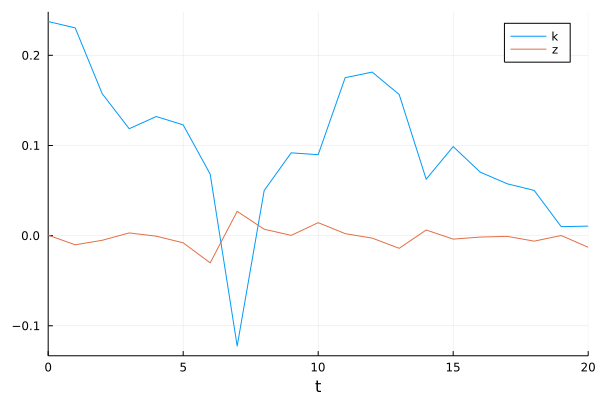

In [8]:
#Solve problem forward with Student-t noise
problem = LinearStateSpaceProblem(sol, x_iv, (0, T); noise)
sim=solve(problem)
# Collapse to simulated observables as a matrix  - as required by current DifferenceEquations.jl likelihood
# see https://github.com/SciML/DifferenceEquations.jl/issues/55 for direct support of this datastructure
z_rbc = hcat(sim.z...)
plot(sim)

That looks like a nice heavy tailed simulation: we see some big swings that might create problems for a Gaussian likelihood. To estimate, build the model in Turing, identical to the benchmark model in the tutorial notebook with Gaussian noise when implemented with the joint approach, but replacing it with Student-t.

In [9]:
using Turing
using Turing: @addlogprob!
Turing.setadbackend(:zygote);  # Especially when we sample the latent noise, we will require high-dimensional gradients with reverse-mode AD

In [10]:
# Turing model definition
@model function rbc_1_t_joint(z, m, p_f, dof, cache, settings)
    α ~ Uniform(0.2, 0.8)
    β ~ Uniform(0.5, 0.99)
    p_d = (; α, β)
    T = size(z, 2)
    xnought ~ filldist(TDist(dof),m.n_x) #Initial shocks 
    ϵ_draw ~ filldist(TDist(dof),m.n_ϵ * T) #Shocks are t-distributed!
    ϵ = reshape(ϵ_draw, m.n_ϵ, T)
    sol = generate_perturbation(m, p_d, p_f, Val(1); cache, settings) 
    if !(sol.retcode == :Success)
        @addlogprob! -Inf
        return
    end
    x_iv = sol.x_ergodic_var * xnought #scale initial condition to ergodic variance
    problem = LinearStateSpaceProblem(sol, x_iv, (0, T), observables = z, noise=ϵ)
    @addlogprob! solve(problem, DirectIteration()).logpdf # should choose DirectIteration() by default if not provided
end
cache = SolverCache(model_rbc, Val(1),  [:α, :β])
settings = PerturbationSolverSettings(; print_level = 0)
p_f = (ρ = 0.2, δ = 0.02, σ = 0.01, Ω_1 = 0.01) # Fixed parameters
z = z_rbc # simulated in previous steps
turing_model = rbc_1_t_joint(z, model_rbc, p_f, dof, cache, settings) # passing observables from before 

n_samples = 300
n_adapts = 50
δ = 0.65
alg = NUTS(n_adapts,δ)
chain_1_joint = sample(turing_model, alg, n_samples; progress = true)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/dchilder/.julia/packages/Turing/S4Y4B/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:08:26


Chains MCMC chain (300×37×1 Array{Float64, 3}):

Iterations        = 51:1:350
Number of chains  = 1
Samples per chain = 300
Wall duration     = 704.9 seconds
Compute duration  = 704.9 seconds
parameters        = α, β, xnought[1], xnought[2], ϵ_draw[1], ϵ_draw[2], ϵ_draw[3], ϵ_draw[4], ϵ_draw[5], ϵ_draw[6], ϵ_draw[7], ϵ_draw[8], ϵ_draw[9], ϵ_draw[10], ϵ_draw[11], ϵ_draw[12], ϵ_draw[13], ϵ_draw[14], ϵ_draw[15], ϵ_draw[16], ϵ_draw[17], ϵ_draw[18], ϵ_draw[19], ϵ_draw[20], ϵ_draw[21]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

           α    0.4580    0.0365     0.0021    0.0057    21.0525    1.0439     ⋯
           β    0.9644    0.0125     0.0007    0

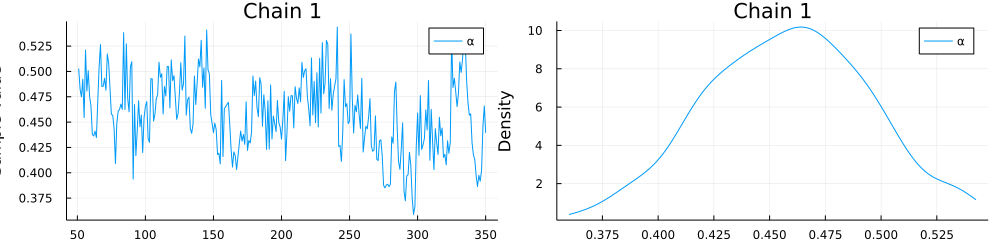

In [11]:
#Plot the chains and posteriors
plot(chain_1_joint[["α"]]; colordim=:parameter, legend=true)

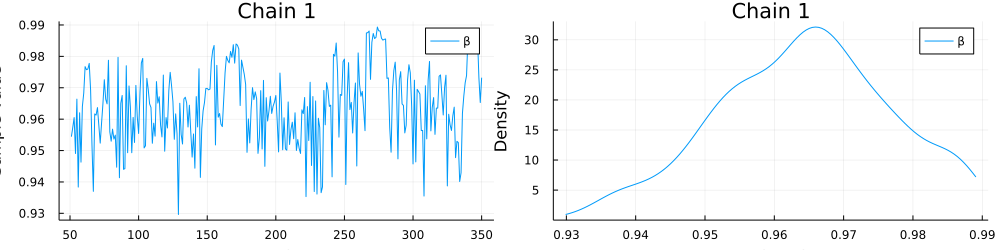

In [12]:
plot(chain_1_joint[["β"]]; colordim=:parameter, legend=true)

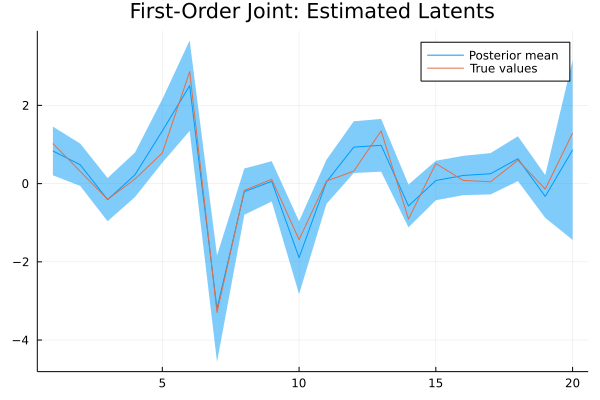

In [13]:
#Plot true and estimated latents to see how well we backed them out
symbol_to_int(s) = parse(Int, string(s)[9:end-1])
ϵ_chain = sort(chain_1_joint[:, [Symbol("ϵ_draw[$a]") for a in 1:21], 1], lt = (x,y) -> symbol_to_int(x) < symbol_to_int(y))
tmp = describe(ϵ_chain)
ϵ_mean = tmp[1][:, 2]
ϵ_std = tmp[1][:, 3]
plot(ϵ_mean[2:end], ribbon=2 * ϵ_std[2:end], label="Posterior mean", title = "First-Order Joint: Estimated Latents")
plot!(noise', label="True values")

That's really pretty good! From the table and plots we also did a decent job with $\alpha$ and $\beta$, for such a short MCMC chain.

So, that was changing to student-t shocks for the latent states. Once we had the data simulated, it required only **one change in the code** in the Turing model, from `MvNormal()` for multivariate normal to `filldist(Tdist())` for a collection of Student-t's. No use of fun special properties of the distribution like the scale-mixture-of-normals representation or fancy Gibbs samplers with closed form marginals were required (nor, thank heavens, anything like a particle filter), just sampling the latent states as if they were parameters. I make no guarantees that this approach is fast, but with HMC it isn't bad at all, and it is very easy, and as a bonus can be carried out with whatever distribution you want, not just well-behaved ones. So go ahead and start fitting your favorite residual error distributions!

### Next step: stochastic volatility

Stochastic volatility should be feasible with similar methods, but requires a bit more of a change from the existing code. The issue here is `LinearStateSpaceProblem` in `DifferenceEquations.jl` is currently set up only for Linear Time Invariant systems, and this extension makes it time varying. Fortunately, iteration is just a for loop, so this will be a nice exercise in demonstrating how to write a function compatible with the reverse mode automatic differentiation system in Zygote.

In [14]:
# Simulate T observations from a random initial condition
T = 50
Random.seed!(12435) #Fix seed to reproduce data
dof = 4 #Student t degrees of freedom
shockdist = TDist(dof) #Shocks are student-t
ρ_σ = 0.5 #Persistence of log volatility
μ_σ = 1. #Mean of (prescaling) volatility
σ_σ = 0.1 #Volatility of volatility

# draw from t scaled by approximate invariant variance) for the initial condition
x_iv = sol.x_ergodic_var * rand(shockdist,sol.n_x)

# Generate noise sequence
noise = Matrix(rand(shockdist,T)') # the ϵ shocks are "noise"
volshocks = Matrix(rand(MvNormal(T,1.0))') # the volatility shocks are log-normal
obsshocks = reshape(rand(MvNormal(T*sol.n_z,p_f[:Ω_1])), sol.n_z, T) #Gaussian observation noise

2×50 Matrix{Float64}:
 0.00247618  -0.00289662  -0.00458003  …  0.00278839  -0.0114459  -0.00497762
 0.0248808    0.010097    -0.0147513      0.00344418  -0.0102173  -0.0177273

The following code is an extension of the code for simulating data from linear state space models in `DifferenceEquations.jl`, extended to add a stochastic volatility element of the form
$$vol_t = \rho_\sigma * vol_{t-1} + (1 - \rho_\sigma) * \mu_\sigma + \sigma_\sigma * \zeta_{t-1}$$
where $log(vol_t)$ is the standard deviation of the shock at time $t$, and $\zeta_{t}$ are i.i.d. normal shocks. (We could make them non-normal, but this is fine for now).

The one thing to note about the way the code is implemented is that it uses exclusively in-place operations inside the loop, which means that it fixes the sequence once then updates it rather than allocating a new variable at each step in the loop. This is a useful programming trick for optimizing memory usage and speed, which is why we used it in the library: see https://book.sciml.ai/ for a wonderful course on writing super efficient Julia code. But it's kind of hard to read, and more importantly, would create problems down the road if we tried to use it directly inside our estimation without some additional tricks. So I'll rewrite it in a simpler way for that task. 

In [15]:
#Extract solution matrices
A = sol.A
B = sol.B
C = sol.C
D = sol.D

# Initialize
u = [zero(x_iv) for _ in 1:T]
u[1] .= x_iv
vol = [zeros(1) for _ in 1:T]
vol[1] = [μ_σ] #Start at mean: could make random but won't for now
#Allocate sequence
z = [zeros(size(C, 1)) for _ in 1:T] 
mul!(z[1], C, u[1])  # update the first of z
for t in 2:T
        mul!(u[t], A, u[t - 1]) # sets u[t] = A * u[t - 1]
        mul!(vol[t], ρ_σ, vol[t-1])
        vol[t] .+= (1 - ρ_σ) * μ_σ
        mul!(vol[t], σ_σ, view(volshocks, :, t - 1),1,1) # adds σ_σ * volshocks[t-1] to vol[t]
        mul!(u[t], exp(vol[t][]) .* B, view(noise, :, t - 1),1,1)
        mul!(z[t], C, u[t]) 
end
for t in 1:T #Add observation noise
        z[t] .+= view(obsshocks,:,t)
end

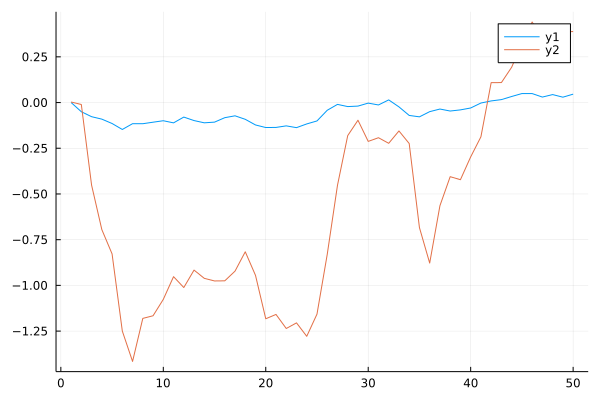

In [16]:
z_data = hcat(z...)
plot(z_data') #Plot k and z from simulation

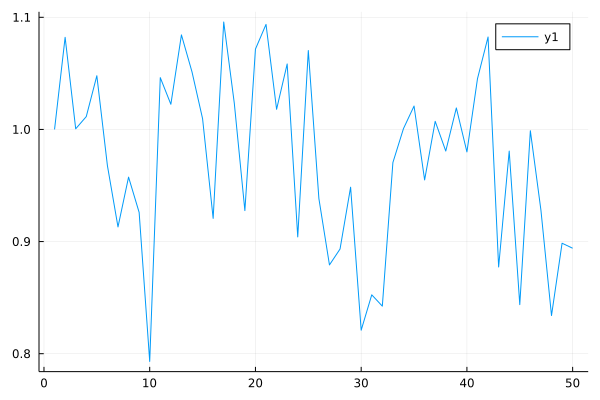

In [17]:
plot(hcat(vol...)') #Plot the latent volatility state

That worked fine for simulation, so the next step is to create the likelihood function corresponding to that simulation. A simple approach would just be take that code and, replace the sampling components with density evaluations, which is essentially how our code in `DifferenceEquations.jl` works.
Unfortunately, I can't do that exactly because the AD framework, `Zygote`, [doesn't allow mutation](https://fluxml.ai/Zygote.jl/latest/limitations/). What this means is that, because it works by following your function along its execution trace, it needs to be able to have a unique address for each evaluation, which gets messed up if your functions work by reallocating the values in an existing object. In practice, this can be resolved either by functional programming or by hiding the non-functional parts away from the AD system.  
There are a few ways to do that in practice.

- One way is by hiding the mutation in an explicitly constructed adjoint function, creating a custom `rrule` in `ChainRules.jl`. This is feasible and can yield highly performant code, which is what we did for the (very similar) adjoint formulas in `DifferenceEquations.jl`. This is also a bit tedious and involves math (mostly [transposing matrices](https://juliadiff.org/ChainRulesCore.jl/dev/maths/arrays.html)), so I'm going to avoid it for now.
    
- Alternately, it ought to be doable by cleaning up the function to avoid the allocation parts. I think that will make things easier than the current code, which uses it for speed and memory reasons, not because of Zygote. Certainly getting rid of all those `mul!` statements ought to make the code easier to read. The only really tricky part about this is that to avoid preallocating the sequences, I will use a special data structure called Zygote.Buffer() which stores the values but isn't touched by the AD, and wrap the code containing the buffer in a function. This is maybe not so performant, but it's easy.
    
*Note to applied researchers for whom the above discussion sounded scary* (eg, me before I spent a hunk of time learning about this stuff): for most common models and operations the AD systems are fully established and you will never have to build these constructs yourself. And if you do end up needing to do so because of some gnarly custom modeling code, tools are getting easier to use: the Python-based AD system JAX has a nice feature called [automatic transposition](https://jax.readthedocs.io/en/latest/notebooks/Custom_derivative_rules_for_Python_code.html) where all you have to do is write a function that computes the derivative of your function of interest.

In [18]:
#Likelihood evaluation function using `Zygote.Buffer()` to create internal arrays that don't interfere with gradients.
function svlikelihood2(A,B,C,D,x_iv,Ω_1,μ_σ,ρ_σ,σ_σ,observables,noise,volshocks) #Accumulate likelihood
    # Initialize
    T = size(observables,2)
    u = Zygote.Buffer([zero(x_iv) for _ in 1:T]) #Fix type: Array of vector of vectors?
    vol = Zygote.Buffer([zeros(1) for _ in 1:T]) #Fix type: Array of vector of vectors?
    u[1] = x_iv 
    vol[1] = [μ_σ] #Start at mean: could make random but won't for now
    for t in 2:T
        vol[t] = ρ_σ * vol[t-1] .+ (1 - ρ_σ) * μ_σ .+ σ_σ * volshocks[t - 1]
        u[t] = A * u[t - 1] .+ exp.(vol[t]) .* (B * noise[t - 1])[:]
    end
    loglik = sum([logpdf(MvNormal(Diagonal(Ω_1 * ones(size(C, 1)))), observables[t] .- C * u[t]) for t in 1:T])
    return loglik
end

ll = svlikelihood2(sol.A,sol.B,sol.C,sol.D,x_iv,p_f[:Ω_1],μ_σ,ρ_σ,σ_σ,z_data,noise,volshocks)

gradient(x_iv->svlikelihood2(sol.A,sol.B,sol.C,sol.D,x_iv,p_f[:Ω_1],μ_σ,ρ_σ,σ_σ,z_data,noise,volshocks),[0., 0.])

([471.50244683819994, 3849.7672753237093],)

As the gradient code demonstrates, automatic differentiation works for this version of the likelihood function.  Now let's stick it in our model.

In [19]:
# Turing model definition
@model function rbc_1_svt_jointseq(z, m, p_f, dof, cache, settings)
    α ~ Uniform(0.2, 0.8)
    β ~ Uniform(0.5, 0.99)
    ρ_σ ~ Beta(2.625, 2.625) #Persistence of log volatility
    μ_σ ~ Normal(1., 0.5) #Mean of (prescaling) volatility
    σ_σ ~ Uniform(0.03, 0.3) #Volatility of volatility
    p_d = (; α, β)
    T = size(z, 2)
    xnought ~ filldist(TDist(dof),m.n_x) #Initial shocks 
    ϵ_draw ~ filldist(TDist(dof),m.n_ϵ * T) #Shocks are t-distributed!
    ϵ = reshape(ϵ_draw, m.n_ϵ, T)
    vsdraw ~ MvNormal(T, 1.0)
    volshocks = reshape(vsdraw,1,T)   
    sol = generate_perturbation(m, p_d, p_f, Val(1); cache, settings) 
    if !(sol.retcode == :Success)
        @addlogprob! -Inf
        return
    end
    x_iv = sol.x_ergodic_var * xnought #scale initial condition to ergodic variance
    @addlogprob! svlikelihood2(sol.A,sol.B,sol.C,sol.D,x_iv,p_f[:Ω_1],μ_σ,ρ_σ,σ_σ,z,ϵ,volshocks)
end

rbc_1_svt_jointseq (generic function with 2 methods)

In [20]:
cache = SolverCache(model_rbc, Val(1),  [:α, :β])
settings = PerturbationSolverSettings(; print_level = 0)
p_f = (ρ = 0.2, δ = 0.02, σ = 0.01, Ω_1 = 0.01) # Fixed parameters
z = z_data # simulated in previous steps
turing_model2 = rbc_1_svt_jointseq(z, model_rbc, p_f, dof, cache, settings) # passing observables from before 

n_samples = 1000
n_adapts = 100
δ = 0.65
alg = NUTS(n_adapts,δ)
chain_2_joint = sample(turing_model2, alg, n_samples; progress = true)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/dchilder/.julia/packages/Turing/S4Y4B/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:40:47


Chains MCMC chain (1000×119×1 Array{Float64, 3}):

Iterations        = 101:1:1100
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 2635.84 seconds
Compute duration  = 2635.84 seconds
parameters        = α, β, ρ_σ, μ_σ, σ_σ, xnought[1], xnought[2], ϵ_draw[1], ϵ_draw[2], ϵ_draw[3], ϵ_draw[4], ϵ_draw[5], ϵ_draw[6], ϵ_draw[7], ϵ_draw[8], ϵ_draw[9], ϵ_draw[10], ϵ_draw[11], ϵ_draw[12], ϵ_draw[13], ϵ_draw[14], ϵ_draw[15], ϵ_draw[16], ϵ_draw[17], ϵ_draw[18], ϵ_draw[19], ϵ_draw[20], ϵ_draw[21], ϵ_draw[22], ϵ_draw[23], ϵ_draw[24], ϵ_draw[25], ϵ_draw[26], ϵ_draw[27], ϵ_draw[28], ϵ_draw[29], ϵ_draw[30], ϵ_draw[31], ϵ_draw[32], ϵ_draw[33], ϵ_draw[34], ϵ_draw[35], ϵ_draw[36], ϵ_draw[37], ϵ_draw[38], ϵ_draw[39], ϵ_draw[40], ϵ_draw[41], ϵ_draw[42], ϵ_draw[43], ϵ_draw[44], ϵ_draw[45], ϵ_draw[46], ϵ_draw[47], ϵ_draw[48], ϵ_draw[49], ϵ_draw[50], vsdraw[1], vsdraw[2], vsdraw[3], vsdraw[4], vsdraw[5], vsdraw[6], vsdraw[7], vsdraw[8], vsdraw[9], vsdraw[10], vsdraw[11], vsdraw[12], vsdraw[1

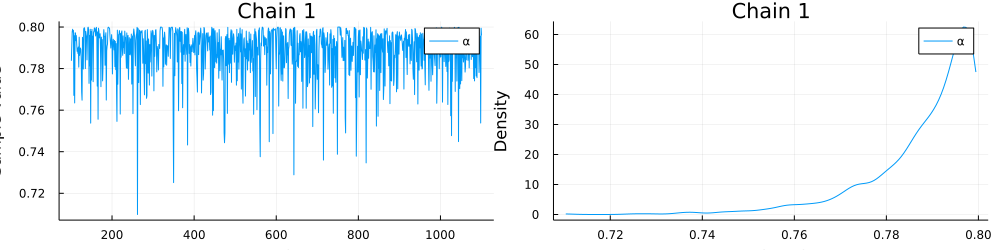

In [21]:
plot(chain_2_joint[["α"]]; colordim=:parameter, legend=true)

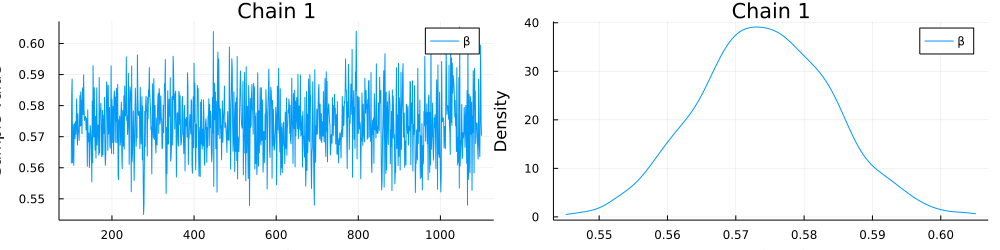

In [22]:
plot(chain_2_joint[["β"]]; colordim=:parameter, legend=true)

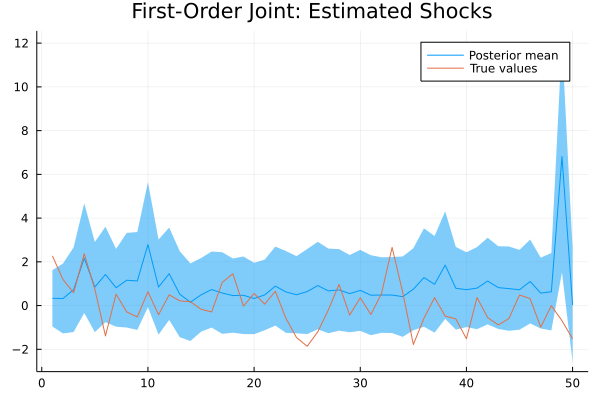

In [23]:
#Plot true and estimated latents to see how well we backed them out
symbol_to_int(s) = parse(Int, string(s)[9:end-1])
ϵ_chain = sort(chain_2_joint[:, [Symbol("ϵ_draw[$a]") for a in 1:50], 1], lt = (x,y) -> symbol_to_int(x) < symbol_to_int(y))
tmp = describe(ϵ_chain)
ϵ_mean = tmp[1][:, 2]
ϵ_std = tmp[1][:, 3]
plot(ϵ_mean[1:end], ribbon=2 * ϵ_std[1:end], label="Posterior mean", title = "First-Order Joint: Estimated Shocks")
plot!(noise', label="True values")

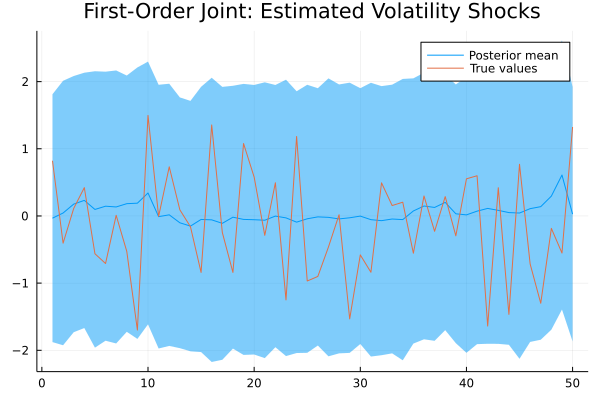

In [24]:
#Plot true and estimated volatility shocks to see how well we backed them out
symbol_to_int(s) = parse(Int, string(s)[8:end-1])
v_chain = sort(chain_2_joint[:, [Symbol("vsdraw[$a]") for a in 1:50], 1], lt = (x,y) -> symbol_to_int(x) < symbol_to_int(y))
tmp = describe(v_chain)
v_mean = tmp[1][:, 2]
v_std = tmp[1][:, 3]
plot(v_mean[1:end], ribbon=2 * v_std[1:end], label="Posterior mean", title = "First-Order Joint: Estimated Volatility Shocks")
plot!(volshocks', label="True values")

That did it! With a little bit of fiddling with data structures to handle some technical issues with automatic differentiation, we built a working probability model incorporating economic structure, non-Gaussian errors, and stochastic volatility. There are plenty of code optimizations that could be done if we wanted to make this faster (see https://book.sciml.ai/ for a comprehensive guide to writing fast Julia), but this gave us a simple working version to start from, that performs okay. The estimation accuracy isn't great here, but I suspect that's a feature of the model rather than the procedure. Specifically, there's just not a lot of info in the data points to back out the time-varying volatilities, so the posterior ends up quite wide and the rest of the parameters are correspondingly harder to estimate. I may consider tighter priors, longer data, or other features improving identification, for future runs.

In terms of economic content, this kind of model is likely to be extremely relevant for studying data post-pandemic, with huge outliers best matched by heavy-tailed distributions, and for dealing with questions where changes in volatility help identify responses ([e.g.](https://itskhoki.com/papers/Mussa.pdf)). Moreover, nothing relied explicitly on the form of the distribution or the volatility shocks, so you could easily incorporate features like skewed shock distributions or even stochastic skewness. Of course, the certainty equivalent case is somewhat limiting here, but you can capture the first order effects of volatility using higher order perturbation solution, which we provide, and, in principle, extend further to more general nonlinear solvers.  